# Esempio di utilizzo della libreria Backtester

Questo notebook mostra come utilizzare la libreria di backtesting che abbiamo creato per testare strategie di trading con le Bollinger Bands.

## 1. Importazione delle librerie

In [1]:
# Importa i moduli della libreria backtester
import sys
sys.path.append('/home/edocame/Desktop/bollingerBands/notebooks')  # Aggiungi il path

from backtester import data_loader, indicators, backtest_engine, visualization, utils
import pandas as pd
import numpy as np

# Importa anche matplotlib per i grafici
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Caricamento e preparazione dei dati

In [2]:
# Carica i dati tick dal file Parquet
file_path = '/home/edocame/Desktop/data_python/03_BID_ASK_DATA/eurchf 1year.parquet'
tick_data = data_loader.load_parquet_data(file_path)

print(f"Dati caricati: {len(tick_data)} righe")
print(f"Periodo: {tick_data.index.min()} - {tick_data.index.max()}")
print(f"Colonne: {tick_data.columns.tolist()}")
print("\nPrime righe:")
print(tick_data.head())

Dati caricati: 57277784 righe
Periodo: 2024-07-12 12:18:14.012000 - 2025-07-11 22:58:56.657000
Colonne: ['bid', 'ask', 'last', 'volume', 'flags']

Prime righe:
                             bid  ask     last  volume  flags
datetime                                                     
2024-07-12 12:18:14.012  0.97548  NaN      NaN     NaN      2
2024-07-12 12:18:17.683      NaN  NaN  0.97548     NaN      8
2024-07-12 12:18:17.683  0.97547  NaN      NaN     NaN      2
2024-07-12 12:18:18.260      NaN  NaN  0.97548     NaN      8
2024-07-12 12:18:18.260  0.97546  NaN      NaN     NaN      2


In [3]:
# Prepara i dati a minuto
minute_data = data_loader.prepare_minute_data(tick_data, resample_rule='1T')

print(f"Dati a minuto: {len(minute_data)} righe")
print(f"Periodo: {minute_data.index.min()} - {minute_data.index.max()}")
print("\nPrime righe:")
print(minute_data.head())

/home/edocame/Desktop/bollingerBands/notebooks/backtester/data_loader.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_sample = tick_data.resample(resample_rule).agg({'bid': 'first', 'ask': 'first'})


Dati a minuto: 368551 righe
Periodo: 2024-07-12 12:18:00 - 2025-07-11 22:58:00

Prime righe:
                         bid      ask  midprice
datetime                                       
2024-07-12 12:18:00  0.97548  0.97548   0.97548
2024-07-12 12:19:00  0.97553  0.97555   0.97554
2024-07-12 12:20:00  0.97558  0.97560   0.97559
2024-07-12 12:21:00  0.97559  0.97561   0.97560
2024-07-12 12:22:00  0.97560  0.97562   0.97561


## 3. Calcolo degli indicatori tecnici

In [4]:
# Calcola le Bollinger Bands
window = 1440  # 24 ore = 1440 minuti
num_std_dev = 1.0

data_with_bands = indicators.bollinger_bands(
    minute_data, 
    price_column='midprice',
    window=window, 
    num_std_dev=num_std_dev
)

# Rimuovi le righe con valori NaN
complete_data = data_with_bands.dropna()

print(f"Dati completi per il backtest: {len(complete_data)} righe")
print(f"Colonne disponibili: {complete_data.columns.tolist()}")
print("\nPrime righe con indicatori:")
print(complete_data.head())

Dati completi per il backtest: 367112 righe
Colonne disponibili: ['bid', 'ask', 'midprice', 'upper_band', 'lower_band', 'middle_band']

Prime righe con indicatori:
                         bid      ask  midprice  upper_band  lower_band  \
datetime                                                                  
2024-07-15 12:28:00  0.97547  0.97550  0.975485    0.975924    0.974852   
2024-07-15 12:29:00  0.97541  0.97544  0.975425    0.975924    0.974852   
2024-07-15 12:30:00  0.97541  0.97544  0.975425    0.975924    0.974852   
2024-07-15 12:31:00  0.97541  0.97543  0.975420    0.975924    0.974852   
2024-07-15 12:32:00  0.97546  0.97551  0.975485    0.975924    0.974852   

                     middle_band  
datetime                          
2024-07-15 12:28:00     0.975388  
2024-07-15 12:29:00     0.975388  
2024-07-15 12:30:00     0.975388  
2024-07-15 12:31:00     0.975388  
2024-07-15 12:32:00     0.975388  


## 4. Esecuzione del backtest

In [5]:
# Crea e esegui il backtest
backtester = backtest_engine.Backtest(complete_data)
results_data = backtester.run()

# Stampa il riassunto delle performance
backtester.print_performance_summary()

=== BACKTEST PERFORMANCE SUMMARY ===
Total Trades: 638
Total PnL: 800.20 pips
Average Trade: 1.25 pips
Win Rate: 73.82%
Winning Trades: 471
Losing Trades: 166
Best Trade: 60.50 pips
Worst Trade: -180.40 pips
Maximum Drawdown: 405.90 pips


## 5. Analisi dei risultati

In [6]:
# Ottieni i risultati come DataFrame
trades_df = backtester.get_trades_dataframe()

if not trades_df.empty:
    print(f"Numero di trade: {len(trades_df)}")
    print("\nPrimi 10 trade:")
    print(trades_df.head(10))
    
    # Statistiche aggiuntive
    win_loss_stats = utils.calculate_win_loss_ratio(trades_df['PnL'])
    print("\nStatistiche Win/Loss:")
    for key, value in win_loss_stats.items():
        print(f"  {key}: {value:.2f}")
else:
    print("Nessun trade eseguito.")

Numero di trade: 638

Primi 10 trade:
    PnL  Direction  Entry_idx  Exit_idx  Cumulative_PnL           Exit_Time
0   2.0         -1        207       377             2.0 2024-07-15 18:45:00
1  -2.4         -1        429       673            -0.4 2024-07-15 23:51:00
2   5.5          1       1096      1307             5.1 2024-07-16 10:25:00
3   3.9         -1       1400      1506             9.0 2024-07-16 13:44:00
4   4.1         -1       1515      1589            13.1 2024-07-16 15:07:00
5   4.0          1       1596      1617            17.1 2024-07-16 15:35:00
6 -85.8          1       1634      4405           -68.7 2024-07-18 14:19:00
7   3.9          1       4426      4613           -64.8 2024-07-18 17:47:00
8   4.3         -1       4639      4773           -60.5 2024-07-18 20:27:00
9   3.7         -1       4809      5407           -56.8 2024-07-19 09:03:00

Statistiche Win/Loss:
  win_rate: 73.82
  loss_rate: 26.02
  avg_win: 8.30
  avg_loss: -18.73
  win_loss_ratio: 0.44
  profit

## 6. Visualizzazione dei risultati

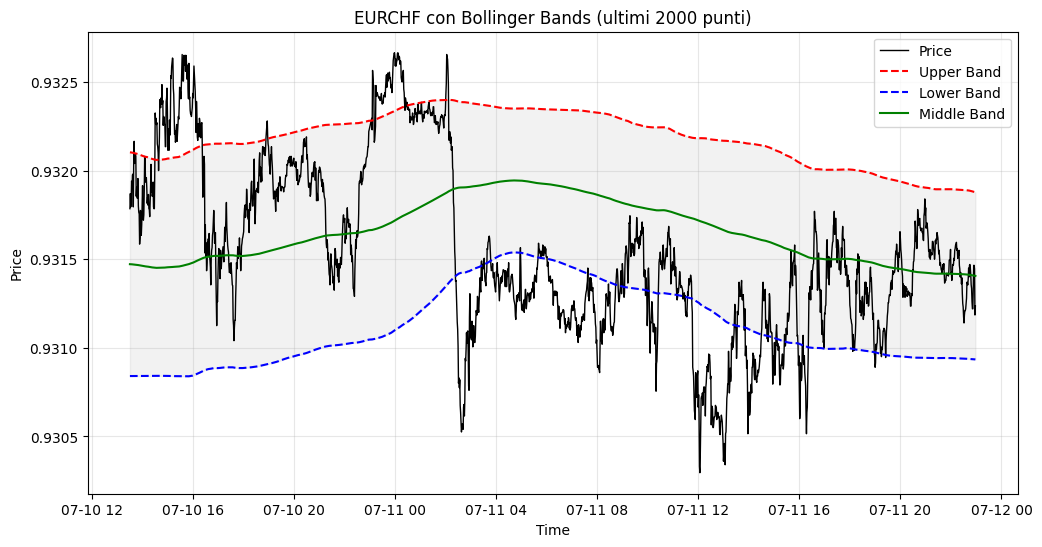

In [7]:
# Visualizza i prezzi con le Bollinger Bands
# Prendi un subset dei dati per una visualizzazione più chiara
subset_data = complete_data.iloc[-2000:]  # Ultimi 2000 punti

visualization.plot_price_with_bollinger_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands (ultimi 2000 punti)"
)

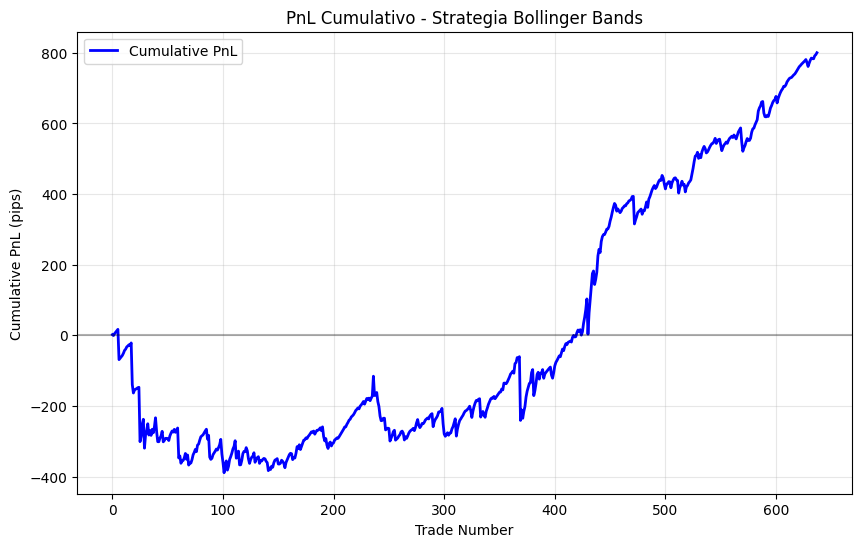

In [8]:
# Visualizza il PnL cumulativo
if not trades_df.empty:
    visualization.plot_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Strategia Bollinger Bands"
    )

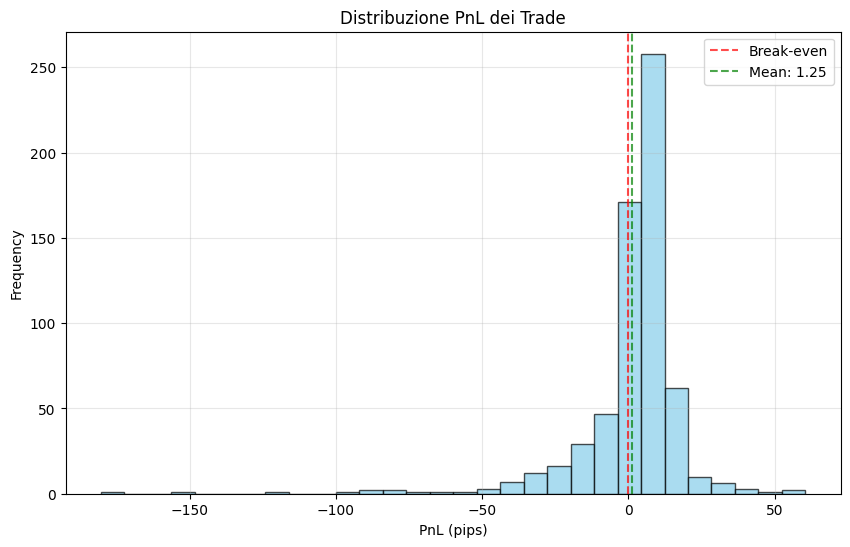

In [9]:
# Visualizza la distribuzione dei trade
if not trades_df.empty:
    visualization.plot_trade_distribution(
        trades_df, 
        title="Distribuzione PnL dei Trade"
    )

## 7. Grafici interattivi (Plotly)

In [10]:
# Grafico interattivo dei prezzi con Bollinger Bands
visualization.plot_interactive_price_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands - Grafico Interattivo"
)

In [11]:
# Grafico interattivo del PnL cumulativo
if not trades_df.empty:
    visualization.plot_interactive_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Grafico Interattivo"
    )

## 8. Confronto con dati reali (se disponibili)

In [17]:
# Carica i dati di balance reali per confronto
try:
    balance_file = '/home/edocame/Desktop/bollingerBands/DATA/eurchf_1440_01.csv'
    balance_data = data_loader.load_balance_data(balance_file)
    
    print(f"Dati balance caricati: {len(balance_data)} righe")
    print(f"Periodo balance: {balance_data.index.min()} - {balance_data.index.max()}")
    
    # Confronta con i risultati del backtest
    if not trades_df.empty:
        # Trova il periodo comune tra backtest e balance
        # Assumiamo che trades_df abbia una colonna 'Exit_Time' con i timestamp
        if 'Exit_Time' in trades_df.columns:
            backtest_start = trades_df['Exit_Time'].min()
            backtest_end = trades_df['Exit_Time'].max()
        else:
            # Se non c'è Exit_Time, usa l'indice del DataFrame completo
            backtest_start = complete_data.index.min()
            backtest_end = complete_data.index.max()
        
        balance_start = balance_data.index.min()
        balance_end = balance_data.index.max()
        
        # Calcola il periodo comune
        common_start = max(backtest_start, balance_start)
        common_end = min(backtest_end, balance_end)
        
        print(f"\nPeriodo backtest: {backtest_start} - {backtest_end}")
        print(f"Periodo balance: {balance_start} - {balance_end}")
        print(f"Periodo comune: {common_start} - {common_end}")
        
        # Verifica che esista un periodo comune
        if common_start <= common_end:
            # Filtra i dati al periodo comune
            if 'Exit_Time' in trades_df.columns:
                trades_common = trades_df[
                    (trades_df['Exit_Time'] >= common_start) & 
                    (trades_df['Exit_Time'] <= common_end)
                ]
            else:
                # Se non c'è Exit_Time, crea un dataset filtrato basato sui timestamp
                trades_common = trades_df.copy()
                
            balance_common = balance_data.loc[common_start:common_end]
            
            print(f"\nTrade nel periodo comune: {len(trades_common)}")
            print(f"Righe balance nel periodo comune: {len(balance_common)}")
            
            # Crea il grafico di confronto solo per il periodo comune
            if len(trades_common) > 0 and len(balance_common) > 0:
                visualization.compare_backtest_vs_real_balance(
                    trades_common, 
                    balance_common, 
                    title=f"Confronto: Backtest vs Balance Reale ({common_start.strftime('%Y-%m-%d')} - {common_end.strftime('%Y-%m-%d')})"
                )
                
                # Mostra anche alcune statistiche di confronto
                print(f"\n=== STATISTICHE PERIODO COMUNE ===")
                print(f"PnL finale backtest: {trades_common['Cumulative_PnL'].iloc[-1]:.2f} pips")
                print(f"Balance finale reale: {balance_common['<BALANCE>'].iloc[-1]:.2f}")
                
                # Calcola la correlazione se possibile
                if len(trades_common) > 1 and len(balance_common) > 1:
                    # Resample per allineare le frequenze
                    try:
                        balance_daily = balance_common['<BALANCE>'].resample('D').last().dropna()
                        trades_daily = trades_common.set_index('Exit_Time')['Cumulative_PnL'].resample('D').last().dropna()
                        
                        # Trova l'intersezione delle date
                        common_dates = balance_daily.index.intersection(trades_daily.index)
                        
                        if len(common_dates) > 2:
                            corr = balance_daily.loc[common_dates].corr(trades_daily.loc[common_dates])
                            print(f"Correlazione giornaliera: {corr:.3f}")
                        else:
                            print("Insufficienti dati per calcolare la correlazione")
                    except Exception as e:
                        print(f"Errore nel calcolo della correlazione: {e}")
            else:
                print("ERRORE: Nessun dato disponibile nel periodo comune filtrato")
        else:
            print("ERRORE: Non ci sono date in comune tra backtest e balance!")
    else:
        print("Nessun trade disponibile per il confronto")
        
except Exception as e:
    print(f"Errore nel caricamento dei dati balance: {e}")

Dati balance caricati: 14673 righe
Periodo balance: 2019-01-01 00:00:00 - 2025-07-07 23:59:00

Periodo backtest: 2024-07-15 18:45:00 - 2025-07-11 19:49:00
Periodo balance: 2019-01-01 00:00:00 - 2025-07-07 23:59:00
Periodo comune: 2024-07-15 18:45:00 - 2025-07-07 23:59:00

Trade nel periodo comune: 623
Righe balance nel periodo comune: 1952



=== STATISTICHE PERIODO COMUNE ===
PnL finale backtest: 763.70 pips
Balance finale reale: 10198.29
Correlazione giornaliera: 0.995


## 9. Dashboard completo

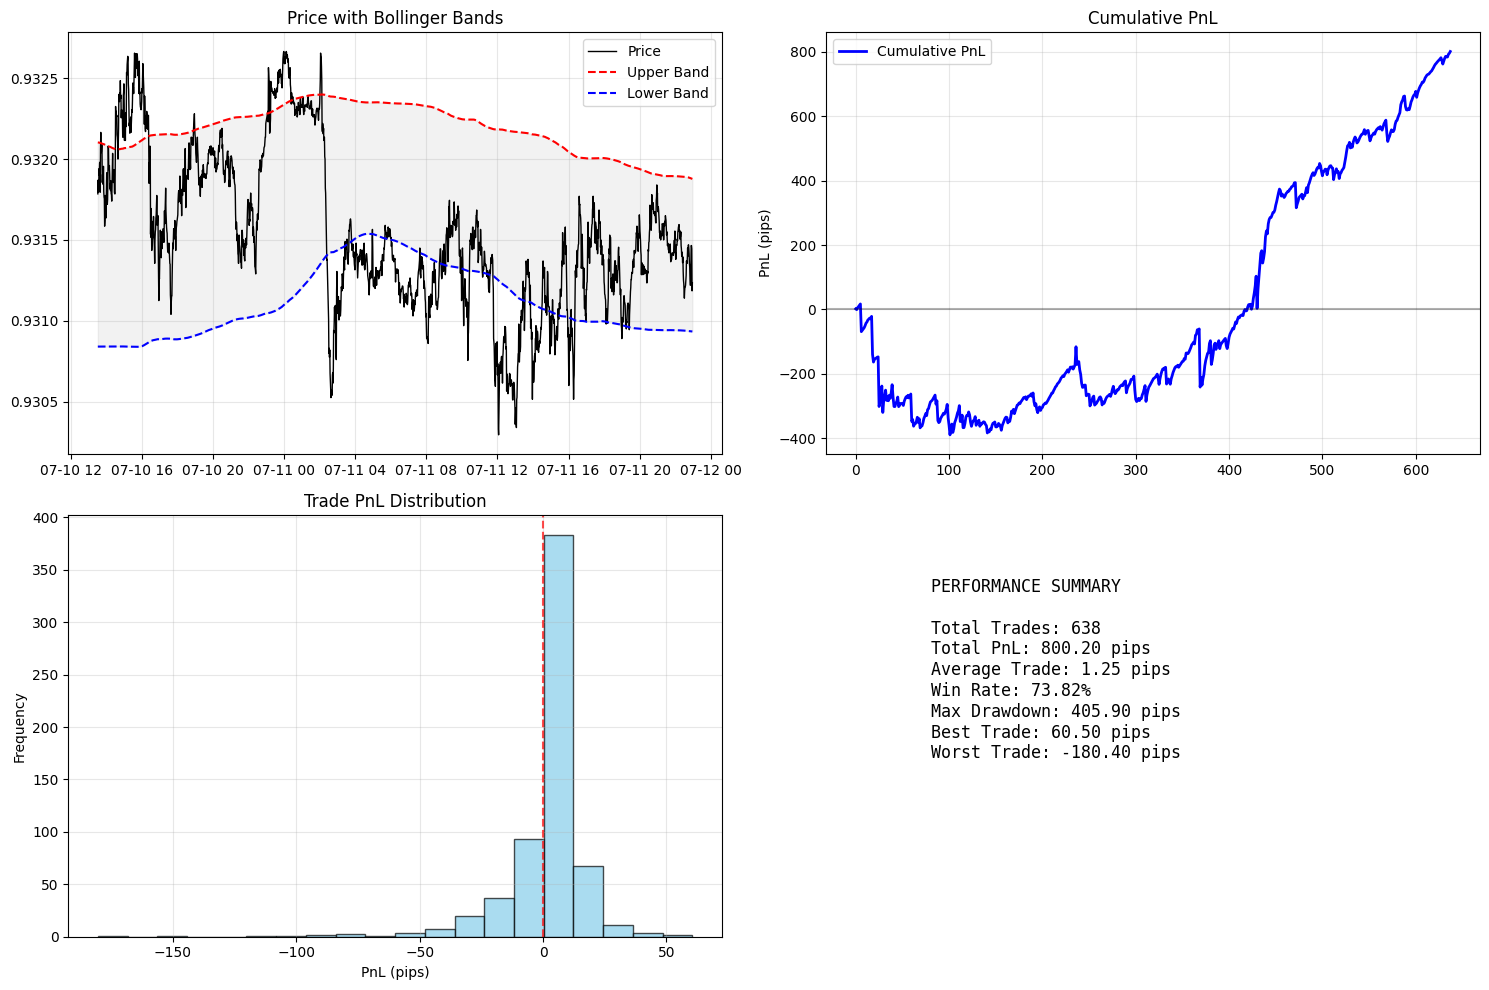

In [13]:
# Crea un dashboard completo con tutti i grafici
if not trades_df.empty:
    visualization.create_performance_dashboard(
        subset_data, 
        trades_df, 
        backtester.performance_metrics
    )

## 10. Test con parametri diversi

In [16]:
# Test rapido con parametri diversi
def test_different_parameters():
    """Test della strategia con diversi parametri."""
    
    parameters_to_test = [
        {'window': 720, 'num_std_dev': 1.0},   # 12 ore, 1 std dev
        {'window': 1440, 'num_std_dev': 1.5},  # 24 ore, 1.5 std dev
        {'window': 2880, 'num_std_dev': 2.0},  # 48 ore, 2 std dev
    ]
    
    results_summary = []
    
    for params in parameters_to_test:
        print(f"\nTesting parameters: {params}")
        
        # Calcola le Bollinger Bands con i nuovi parametri
        test_data = indicators.bollinger_bands(
            minute_data, 
            price_column='midprice',
            window=params['window'], 
            num_std_dev=params['num_std_dev']
        )
        
        test_data_clean = test_data.dropna()
        
        if len(test_data_clean) > 100:  # Assicurati di avere abbastanza dati
            # Esegui il backtest
            test_backtester = backtest_engine.Backtest(test_data_clean)
            test_backtester.run()
            
            # Salva i risultati
            results_summary.append({
                'window': params['window'],
                'num_std_dev': params['num_std_dev'],
                'total_trades': test_backtester.performance_metrics['total_trades'],
                'total_pnl': test_backtester.performance_metrics['total_pnl'],
                'win_rate': test_backtester.performance_metrics['win_rate'],
                'max_drawdown': test_backtester.performance_metrics['max_drawdown']
            })
    
    # Mostra i risultati
    results_df = pd.DataFrame(results_summary)
    print("\n=== CONFRONTO PARAMETRI ===")
    print(results_df.to_string(index=False))
    
    return results_df

# Esegui il test
parameter_results = test_different_parameters()


Testing parameters: {'window': 720, 'num_std_dev': 1.0}

Testing parameters: {'window': 1440, 'num_std_dev': 1.5}

Testing parameters: {'window': 2880, 'num_std_dev': 2.0}

=== CONFRONTO PARAMETRI ===
 window  num_std_dev  total_trades  total_pnl  win_rate  max_drawdown
    720          1.0          1316     -124.6 73.328267         840.1
   1440          1.5           454      767.2 70.484581         464.4
   2880          2.0           168      975.5 79.761905         400.6
